**Get the data for the model training**

In this part of the code we will import the RNA-seq and CITE-seq data and start exploring potential models. First we would get the data in and convert it into the standard data format.

In [102]:

# Import standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from sklearn.preprocessing import StandardScaler

# standard regression models
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.cross_decomposition import PLSRegression

# xgboost
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor


### Import the data and convert

In [8]:


# Protein expression data
pd_prot_exp = pd.read_csv('/home/ec2-user/modal_form/CrossModalFormer_CITE_Seq/Code/CrossModalFormer/Data/documentation/Protein_expression.csv')


In [5]:

# RNA expression data
rna_exp = sc.read_csv('/home/ec2-user/modal_form/CrossModalFormer_CITE_Seq/Code/CrossModalFormer/Data/expression/RNA_expression_subset1a.csv')


In [6]:

# get cell and gene names
cell_names = rna_exp.var.index.values
gene_names = rna_exp.obs.index.values

# transpose the data
rna_exp = rna_exp.T


In [ ]:

# save pre-processed data to h5ad
rna_exp.write_h5ad('/home/ec2-user/modal_form/CrossModalFormer_CITE_Seq/Code/CrossModalFormer/Data/expression/RNA_expression_subset1a.h5ad')


In [68]:

# read the processed data again
rna_exp = sc.read_h5ad('/home/ec2-user/modal_form/CrossModalFormer_CITE_Seq/Code/CrossModalFormer/Data/expression/RNA_expression_subset1a.h5ad')

# add cell names values
cell_names = rna_exp.obs.index.values


### Pre-process the data

In [69]:

# pre-process RNA-seq data
sc.pp.normalize_total(rna_exp, target_sum=1e4)
sc.pp.log1p(rna_exp)
# use only highly variable genes
sc.pp.highly_variable_genes(rna_exp, n_top_genes=3000, subset=True)


In [48]:
# preprocess protein data
pd_prot_exp_norm=pd_prot_exp.copy()

# drop protein column
pd_prot_exp_norm=pd_prot_exp_norm.drop(columns=['Protein'])

# normalize protein data
scaler = StandardScaler()
pd_prot_exp_norm = scaler.fit_transform(pd_prot_exp_norm)

# give back cell ids
pd_prot_exp_norm = pd.DataFrame(pd_prot_exp_norm, columns=pd_prot_exp.columns.values[1:])


### Find matching cells

In [70]:

# find common columns
cell_idx = np.intersect1d(cell_names, pd_prot_exp_norm.columns.values)

In [87]:

# select proteins by cells
Y_protein = pd_prot_exp_norm[cell_idx]
# transpose proteins
Y_protein = Y_protein.T 
protein_names = pd_prot_exp['Protein'].values

# RNA-seq
X_rna = rna_exp[cell_idx,:].X


### Model gene to protein relationship

In this part we will fit linear (i) ridge regression, (ii) partial least squares and (iii) xgboost to predict protein levels from scRNA-seq signal. 
To evaluate the goodness of fit we use R2 computed across measured (Y_protein) and predicted (Y_pred) protein expression. One couls see that xgboost on average is producing the
best model in terms of explained variance.

In [96]:

### Ridge regression

model_ridge = Ridge(alpha=1.0)
model_ridge.fit(X_rna, Y_protein)

Y_pred = model_ridge.predict(X_rna)
print("R2:", r2_score(Y_protein, Y_pred, multioutput='uniform_average'))


R2: 0.24875757098197937


In [97]:
### Partial least squares

# fit the model
model_pls = PLSRegression(n_components=10)
model_pls.fit(X_rna, Y_protein)

# check predictions
Y_pred = model_pls.predict(X_rna)
print("R2:", r2_score(Y_protein, Y_pred, multioutput='uniform_average'))


R2: 0.14758080892283532


In [103]:
# xgboost

# create multi-output regressor
model_xgb = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        n_jobs=-1,
        random_state=42
    )
)

# fit the model
model_xgb.fit(X_rna, Y_protein)

# check predictions
Y_pred = model_xgb.predict(X_rna)
print("R2 (avg across proteins):", r2_score(Y_protein, Y_pred, multioutput='uniform_average'))


R2 (avg across proteins): 0.4580128788948059


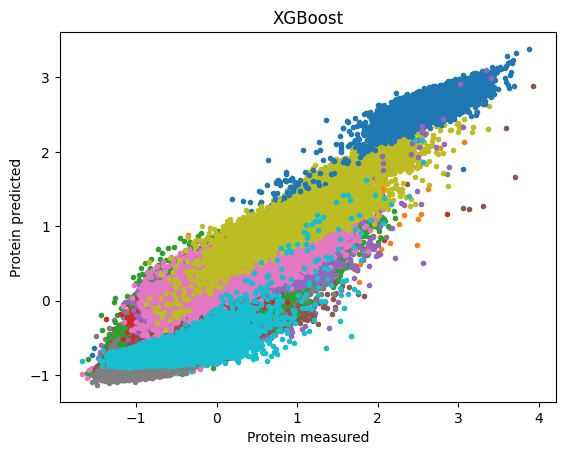

In [109]:

# plot xgboost results
plt.plot(Y_protein,Y_pred,'.')
plt.ylabel('Protein predicted')
plt.xlabel('Protein measured')
plt.title('XGBoost')
plt.show()


In [104]:

# add output per protein
r2_per_protein = r2_score(Y_protein, Y_pred, multioutput='raw_values')
for i, r2 in enumerate(r2_per_protein):
    print(f"Protein {i}: R² = {r2:.3f}")


Protein 0: R² = 0.403
Protein 1: R² = 0.472
Protein 2: R² = 0.381
Protein 3: R² = 0.377
Protein 4: R² = 0.335
Protein 5: R² = 0.342
Protein 6: R² = 0.383
Protein 7: R² = 0.599
Protein 8: R² = 0.613
Protein 9: R² = 0.369
Protein 10: R² = 0.589
Protein 11: R² = 0.546
Protein 12: R² = 0.644
Protein 13: R² = 0.465
Protein 14: R² = 0.404
Protein 15: R² = 0.447
Protein 16: R² = 0.517
Protein 17: R² = 0.394
Protein 18: R² = 0.524
Protein 19: R² = 0.359
